In [ ]:
pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 11.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU, Dense, Dropout, Layer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from contractions import fix
import nltk

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras.layers import GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from keras.models import Sequential
from keras.layers import Embedding, Dropout, Conv1D, MaxPooling1D, LSTM, Dense
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss, hamming_loss
import numpy as np

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, backend as K
from tensorflow.keras import activations
from tensorflow.keras.activations import *
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense

from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import activations
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers

import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.constraints import *
from tensorflow.keras.initializers import *
from tensorflow.keras.regularizers import *
from tensorflow.keras.layers import Lambda

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/A/A_forSkripsiii/train.csv')

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', 'url', text)
    text = re.sub(r'@\w+', 'username', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\d+', 'number', text)
    text = fix(text)
    text = ' '.join(word_tokenize(text))
    return text

# Apply preprocessing
text_column = 'comment_text'
data[text_column] = data[text_column].astype(str).apply(preprocess_text)

# Load saved tokenizer
with open('/content/drive/MyDrive/A/A_forSkripsiii/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Use tokenizer to transform text
max_len = 200
max_words = 20000
sequences = tokenizer.texts_to_sequences(data[text_column])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Define labels
labels = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)


In [ ]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
import tensorflow as tf

class SquashActivation(layers.Layer):
    def call(self, inputs):
        s_squared_norm = tf.reduce_sum(tf.square(inputs), axis=-1, keepdims=True) + tf.keras.backend.epsilon()
        scale = tf.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
        return scale * inputs

    def get_config(self):
        return super().get_config()


In [ ]:
class Capsule(layers.Layer):
    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 initializer='glorot_uniform',
                 activation=None,
                 regularizer=None,
                 constraint=None,
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights

        self.activation = activations.get(activation)
        self.regularizer = regularizers.get(regularizer)
        self.initializer = initializers.get(initializer)
        self.constraint = constraints.get(constraint)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(1,
                                            input_dim_capsule,
                                            self.num_capsule *
                                            self.dim_capsule),
                                     initializer=self.initializer,
                                     regularizer=self.regularizer,
                                     constraint=self.constraint,
                                     trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.W = self.add_weight(name='capsule_kernel',
                                     shape=(input_num_capsule,
                                            input_dim_capsule,
                                            self.num_capsule *
                                            self.dim_capsule),
                                     initializer=self.initializer,
                                     regularizer=self.regularizer,
                                     constraint=self.constraint,
                                     trainable=True)

        self.build = True

    def call(self, inputs):
        if self.share_weights:
            u_hat_vectors = K.conv1d(inputs, self.W)
        else:
            u_hat_vectors = K.local_conv1d(inputs, self.W, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        u_hat_vectors = K.reshape(u_hat_vectors, (batch_size,
                                                  input_num_capsule,
                                                  self.num_capsule,
                                                  self.dim_capsule))

        u_hat_vectors = K.permute_dimensions(u_hat_vectors, (0, 2, 1, 3))
        routing_weights = K.zeros_like(u_hat_vectors[:, :, :, 0])

        for i in range(self.routings):
            capsule_weights = K.softmax(routing_weights, 1)
            outputs = K.batch_dot(capsule_weights, u_hat_vectors, [2, 2])
            if K.ndim(outputs) == 4:
                outputs = K.sum(outputs, axis=1)
            if i < self.routings - 1:
                outputs = K.l2_normalize(outputs, -1)
                routing_weights = K.batch_dot(outputs, u_hat_vectors, [2, 3])
                if K.ndim(routing_weights) == 4:
                    routing_weights = K.sum(routing_weights, axis=1)

        return self.activation(outputs)

    def compute_output_shape(self, input_shape):
        return (None, self.num_capsule, self.dim_capsule)

    def get_config(self):
        config = super(Capsule, self).get_config()
        config.update({
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings,
            'share_weights': self.share_weights,
            'activation': activations.serialize(self.activation),
            'initializer': initializers.serialize(self.initializer),
            'regularizer': regularizers.serialize(self.regularizer),
            'constraint': constraints.serialize(self.constraint)
        })
        return config


In [ ]:
# List of epochs to train for
# (dim_capsule, routings)
dims = [4, 8, 16, 32, 64]
routings = [3, 4, 5, 6, 7]
capsule_configs = [(d, r) for d in dims for r in routings]

In [ ]:
# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

embedding_dim = 256
batch_size = 64
epochs = 5

# List
dims = [32, 64]
routings = [3, 4, 5, 6, 7]
capsule_configs = [(d, r) for d in dims for r in routings]

train_losses = []
val_losses = []
accuracies = []
log_losses = []  # To store log loss for each epoch
hamming_losses = []  # To store hamming loss for each epoch

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint



Dim_capsule=32, routings=3...


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_24 (Embedding)        │ (64, 200, 256)         │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (64, 200, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (64, 196, 64)          │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_24 (MaxPooling1D) │ (64, 49, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (64, 49, 100)          │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_24 (Capsule)            │ (None, 6, 32)          │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 6)              │         1,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,288,342 (20.17 MB)

 Trainable params: 5,288,342 (20.17 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9743 - loss: 0.1209
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing3_epoch01.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.9743 - loss: 0.1209 - val_accuracy: 0.9940 - val_loss: 0.0498
Epoch 2/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9920 - loss: 0.0460
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing3_epoch02.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9920 - loss: 0.0460 - val_accuracy: 0.9940 - val_loss: 0.0475
Epoch 3/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9480 - loss: 0.0389
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing3_epoch03.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9480 - loss: 0.0389 - val_accuracy: 0.9891 - val_loss: 0.0502
Epoch 4/5
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8408 - loss: 0.0320
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing3_epoch04.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.8408 - loss: 0.0320 - val_accuracy: 0.9004 - val_loss: 0.0530
Epoch 5/5
1742/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7515 - loss: 0.0266
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing3_epoch05.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.7514 - loss: 0.0266 - val_accuracy: 0.4102 - val_loss: 0.0630
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.4111 - loss: 0.0619
dim_capsule=32, routings=3 - Validation loss: 0.06295793503522873
dim_capsule=32, routings=3 - Validation accuracy: 0.4102398157119751
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


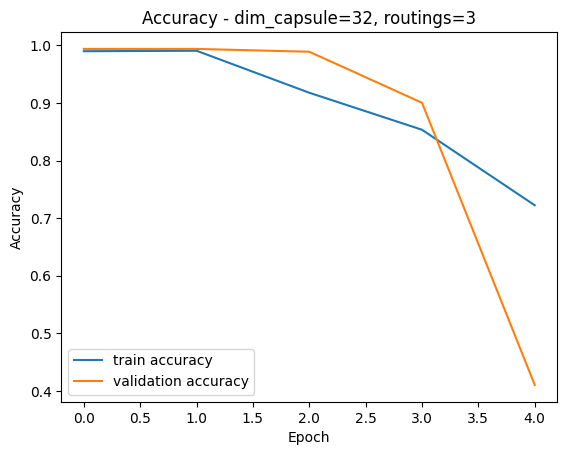

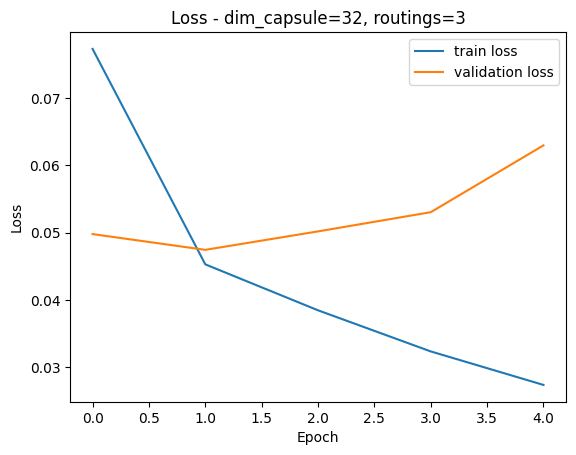


Dim_capsule=32, routings=4...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_25 (Embedding)        │ (64, 200, 256)         │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (64, 200, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (64, 196, 64)          │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_25 (MaxPooling1D) │ (64, 49, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (64, 49, 100)          │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_25 (Capsule)            │ (None, 6, 32)          │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 6)              │         1,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,288,342 (20.17 MB)

 Trainable params: 5,288,342 (20.17 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1742/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9618 - loss: 0.1229
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing4_epoch01.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.9618 - loss: 0.1228 - val_accuracy: 0.9940 - val_loss: 0.0498
Epoch 2/5
1744/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9546 - loss: 0.0455
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing4_epoch02.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.9546 - loss: 0.0455 - val_accuracy: 0.9908 - val_loss: 0.0486
Epoch 3/5
1744/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8914 - loss: 0.0366
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing4_epoch03.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.8913 - loss: 0.0366 - val_accuracy: 0.8063 - val_loss: 0.0510
Epoch 4/5
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7773 - loss: 0.0299
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing4_epoch04.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.7773 - loss: 0.0299 - val_accuracy: 0.4709 - val_loss: 0.0542
Epoch 5/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4679 - loss: 0.0251
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing4_epoch05.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.4679 - loss: 0.0251 - val_accuracy: 0.4783 - val_loss: 0.0584
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4784 - loss: 0.0569
dim_capsule=32, routings=4 - Validation loss: 0.05844622477889061
dim_capsule=32, routings=4 - Validation accuracy: 0.47831717133522034
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


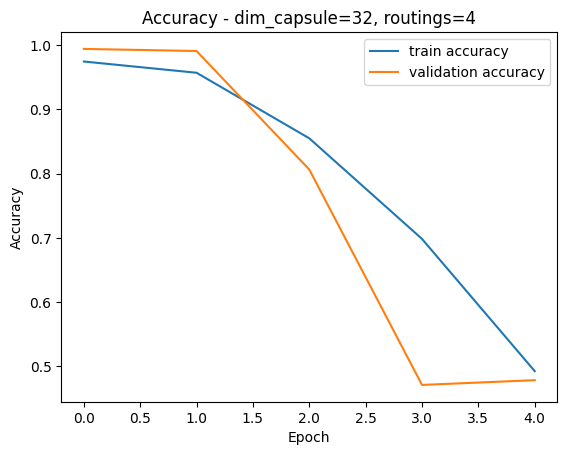

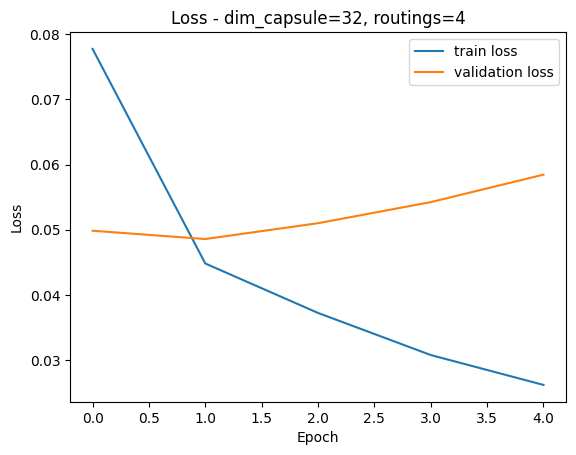


Dim_capsule=32, routings=5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_26 (Embedding)        │ (64, 200, 256)         │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (64, 200, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_26 (Conv1D)              │ (64, 196, 64)          │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (64, 49, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (64, 49, 100)          │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_26 (Capsule)            │ (None, 6, 32)          │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 6)              │         1,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,288,342 (20.17 MB)

 Trainable params: 5,288,342 (20.17 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9699 - loss: 0.1186
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing5_epoch01.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.9699 - loss: 0.1186 - val_accuracy: 0.9940 - val_loss: 0.0525
Epoch 2/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9931 - loss: 0.0462
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing5_epoch02.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9931 - loss: 0.0462 - val_accuracy: 0.9940 - val_loss: 0.0488
Epoch 3/5
1744/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9580 - loss: 0.0381
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing5_epoch03.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.9580 - loss: 0.0381 - val_accuracy: 0.9940 - val_loss: 0.0522
Epoch 4/5
1742/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7630 - loss: 0.0330
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing5_epoch04.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.7629 - loss: 0.0330 - val_accuracy: 0.9939 - val_loss: 0.0522
Epoch 5/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5970 - loss: 0.0282
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing5_epoch05.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.5970 - loss: 0.0282 - val_accuracy: 0.4442 - val_loss: 0.0586
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4423 - loss: 0.0585
dim_capsule=32, routings=5 - Validation loss: 0.058645136654376984
dim_capsule=32, routings=5 - Validation accuracy: 0.44416359066963196
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


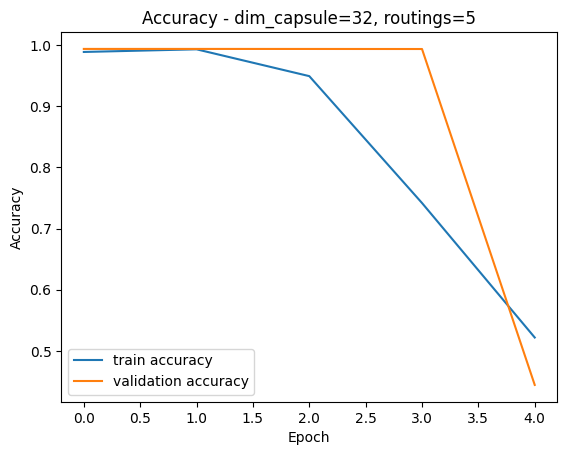

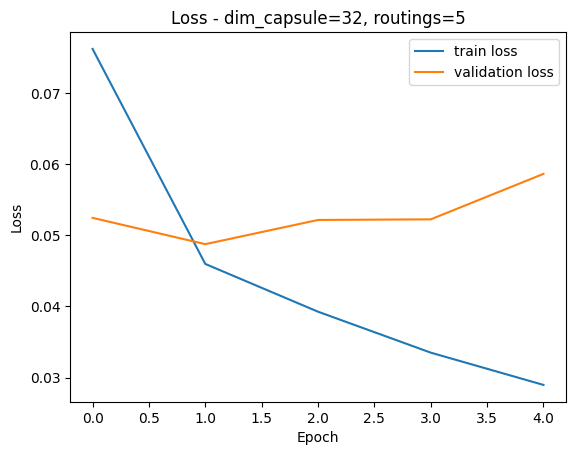


Dim_capsule=32, routings=6...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_27 (Embedding)        │ (64, 200, 256)         │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (64, 200, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_27 (Conv1D)              │ (64, 196, 64)          │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (64, 49, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (64, 49, 100)          │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_27 (Capsule)            │ (None, 6, 32)          │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_27 (Flatten)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 6)              │         1,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,288,342 (20.17 MB)

 Trainable params: 5,288,342 (20.17 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9205 - loss: 0.1199
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing6_epoch01.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.9206 - loss: 0.1198 - val_accuracy: 0.9940 - val_loss: 0.0505
Epoch 2/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9875 - loss: 0.0448
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing6_epoch02.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9875 - loss: 0.0448 - val_accuracy: 0.9940 - val_loss: 0.0500
Epoch 3/5
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9051 - loss: 0.0379
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing6_epoch03.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9050 - loss: 0.0379 - val_accuracy: 0.9717 - val_loss: 0.0510
Epoch 4/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6529 - loss: 0.0311
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing6_epoch04.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.6529 - loss: 0.0311 - val_accuracy: 0.6305 - val_loss: 0.0528
Epoch 5/5
1744/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5308 - loss: 0.0266
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing6_epoch05.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.5308 - loss: 0.0266 - val_accuracy: 0.8777 - val_loss: 0.0575
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8775 - loss: 0.0561
dim_capsule=32, routings=6 - Validation loss: 0.057524941861629486
dim_capsule=32, routings=6 - Validation accuracy: 0.8776738047599792
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


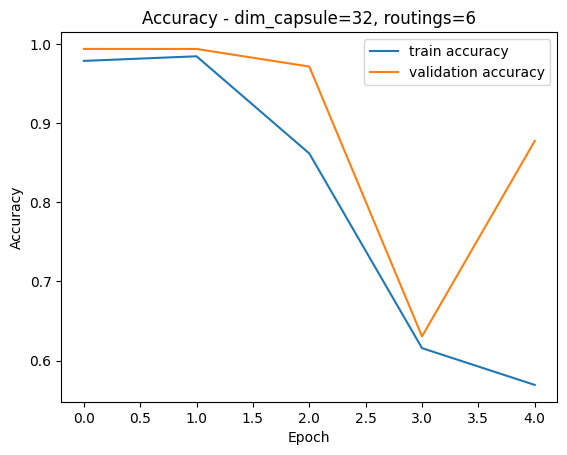

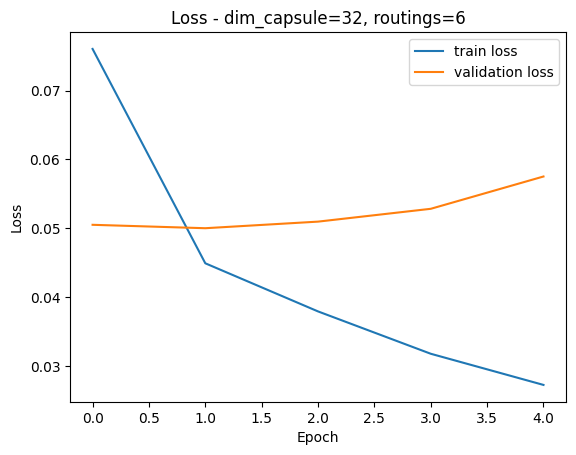


Dim_capsule=32, routings=7...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)        │ (64, 200, 256)         │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (64, 200, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (64, 196, 64)          │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (64, 49, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (64, 49, 100)          │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_28 (Capsule)            │ (None, 6, 32)          │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 6)              │         1,158 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,288,342 (20.17 MB)

 Trainable params: 5,288,342 (20.17 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8935 - loss: 0.1186
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing7_epoch01.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.8936 - loss: 0.1185 - val_accuracy: 0.9940 - val_loss: 0.0500
Epoch 2/5
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9817 - loss: 0.0453
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing7_epoch02.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.9817 - loss: 0.0453 - val_accuracy: 0.9940 - val_loss: 0.0494
Epoch 3/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8995 - loss: 0.0380
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing7_epoch03.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.8994 - loss: 0.0380 - val_accuracy: 0.6343 - val_loss: 0.0527
Epoch 4/5
1744/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7079 - loss: 0.0308
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing7_epoch04.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.7078 - loss: 0.0308 - val_accuracy: 0.4718 - val_loss: 0.0546
Epoch 5/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5577 - loss: 0.0275
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim32_routing7_epoch05.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.5577 - loss: 0.0275 - val_accuracy: 0.7472 - val_loss: 0.0561
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.7468 - loss: 0.0556
dim_capsule=32, routings=7 - Validation loss: 0.05613917112350464
dim_capsule=32, routings=7 - Validation accuracy: 0.7472008466720581
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


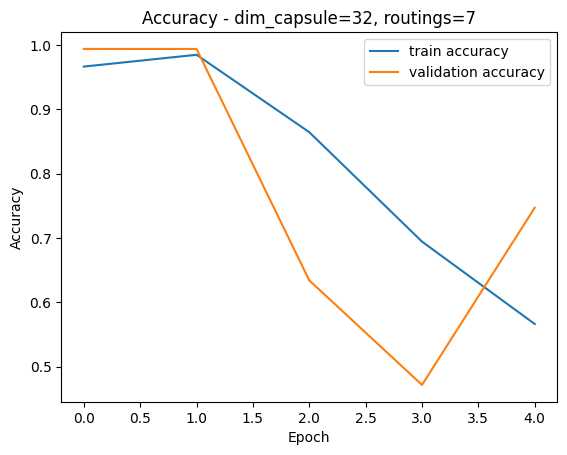

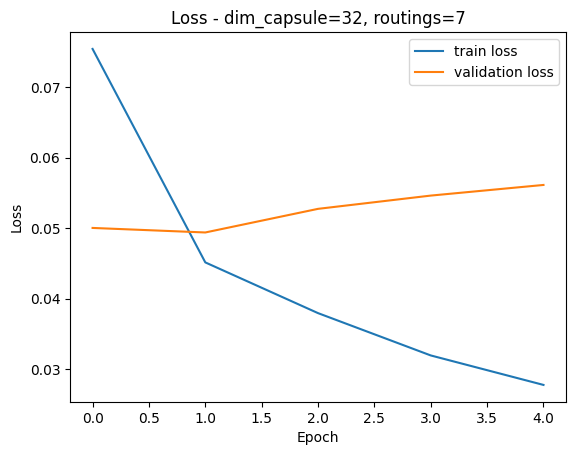


Dim_capsule=64, routings=3...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)        │ (64, 200, 256)         │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (64, 200, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (64, 196, 64)          │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (64, 49, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (64, 49, 100)          │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_29 (Capsule)            │ (None, 6, 64)          │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_29 (Flatten)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 6)              │         2,310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,308,694 (20.25 MB)

 Trainable params: 5,308,694 (20.25 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9571 - loss: 0.1170
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing3_epoch01.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.9571 - loss: 0.1170 - val_accuracy: 0.9940 - val_loss: 0.0508
Epoch 2/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9825 - loss: 0.0457
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing3_epoch02.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.9825 - loss: 0.0457 - val_accuracy: 0.9940 - val_loss: 0.0497
Epoch 3/5
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8960 - loss: 0.0382
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing3_epoch03.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.8960 - loss: 0.0382 - val_accuracy: 0.9938 - val_loss: 0.0488
Epoch 4/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7856 - loss: 0.0318
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing3_epoch04.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.7856 - loss: 0.0318 - val_accuracy: 0.6955 - val_loss: 0.0531
Epoch 5/5
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5642 - loss: 0.0265
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing3_epoch05.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - accuracy: 0.5642 - loss: 0.0265 - val_accuracy: 0.5924 - val_loss: 0.0560
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5917 - loss: 0.0548
dim_capsule=64, routings=3 - Validation loss: 0.05601810663938522
dim_capsule=64, routings=3 - Validation accuracy: 0.5924339890480042
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


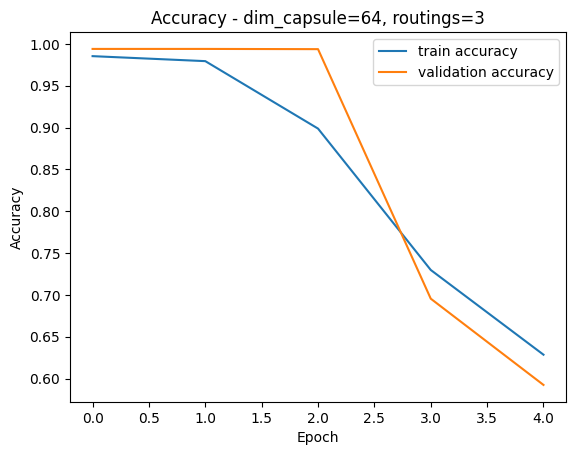

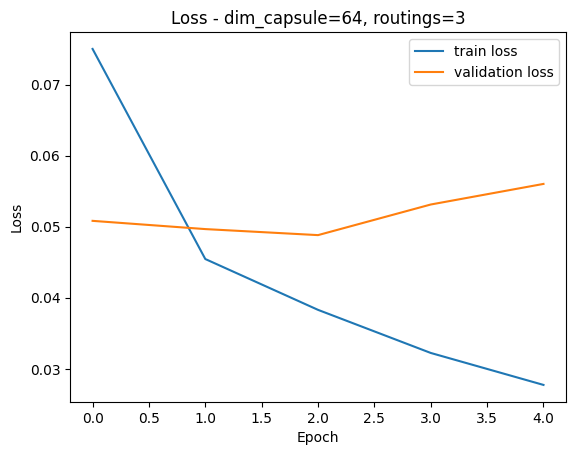


Dim_capsule=64, routings=4...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_30 (Embedding)        │ (64, 200, 256)         │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (64, 200, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_30 (Conv1D)              │ (64, 196, 64)          │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_30 (MaxPooling1D) │ (64, 49, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_30 (LSTM)                  │ (64, 49, 100)          │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_30 (Capsule)            │ (None, 6, 64)          │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_30 (Flatten)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 6)              │         2,310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,308,694 (20.25 MB)

 Trainable params: 5,308,694 (20.25 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1742/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9820 - loss: 0.1146
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing4_epoch01.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.9820 - loss: 0.1145 - val_accuracy: 0.9940 - val_loss: 0.0494
Epoch 2/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9718 - loss: 0.0451
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing4_epoch02.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9718 - loss: 0.0451 - val_accuracy: 0.9940 - val_loss: 0.0480
Epoch 3/5
1742/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8625 - loss: 0.0371
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing4_epoch03.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.8624 - loss: 0.0371 - val_accuracy: 0.9837 - val_loss: 0.0505
Epoch 4/5
1742/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7743 - loss: 0.0312
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing4_epoch04.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.7742 - loss: 0.0312 - val_accuracy: 0.4266 - val_loss: 0.0552
Epoch 5/5
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4411 - loss: 0.0259
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing4_epoch05.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - accuracy: 0.4411 - loss: 0.0259 - val_accuracy: 0.4310 - val_loss: 0.0594
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.4291 - loss: 0.0584
dim_capsule=64, routings=4 - Validation loss: 0.05940398946404457
dim_capsule=64, routings=4 - Validation accuracy: 0.43100351095199585
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


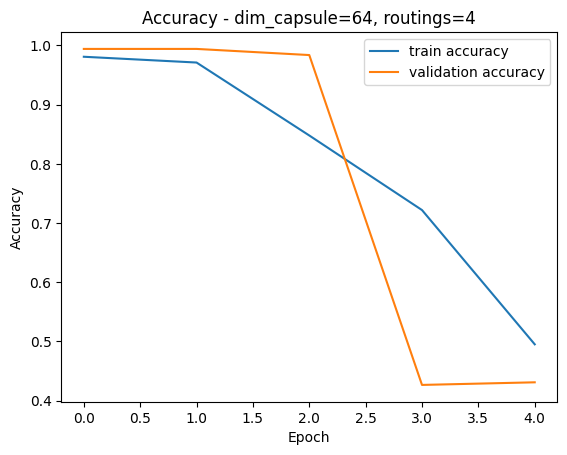

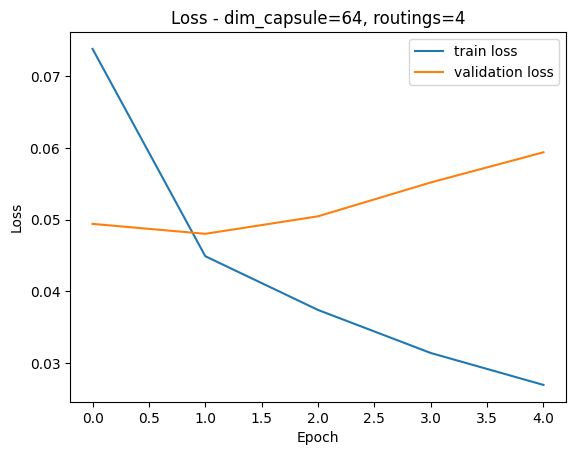


Dim_capsule=64, routings=5...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)        │ (64, 200, 256)         │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (64, 200, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_31 (Conv1D)              │ (64, 196, 64)          │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_31 (MaxPooling1D) │ (64, 49, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_31 (LSTM)                  │ (64, 49, 100)          │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_31 (Capsule)            │ (None, 6, 64)          │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_31 (Flatten)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 6)              │         2,310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,308,694 (20.25 MB)

 Trainable params: 5,308,694 (20.25 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1743/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9277 - loss: 0.1175
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing5_epoch01.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.9279 - loss: 0.1174 - val_accuracy: 0.9940 - val_loss: 0.0520
Epoch 2/5
1744/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9777 - loss: 0.0462
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing5_epoch02.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9777 - loss: 0.0462 - val_accuracy: 0.9912 - val_loss: 0.0483
Epoch 3/5
1743/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9011 - loss: 0.0382
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing5_epoch03.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9011 - loss: 0.0382 - val_accuracy: 0.9938 - val_loss: 0.0510
Epoch 4/5
1742/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6919 - loss: 0.0320
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing5_epoch04.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.6920 - loss: 0.0320 - val_accuracy: 0.7287 - val_loss: 0.0529
Epoch 5/5
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5824 - loss: 0.0274
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing5_epoch05.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.5825 - loss: 0.0274 - val_accuracy: 0.8036 - val_loss: 0.0607
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8056 - loss: 0.0599
dim_capsule=64, routings=5 - Validation loss: 0.06073249876499176
dim_capsule=64, routings=5 - Validation accuracy: 0.8036639094352722
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


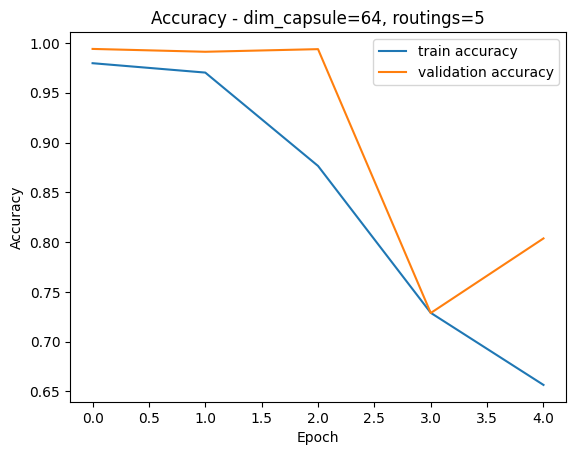

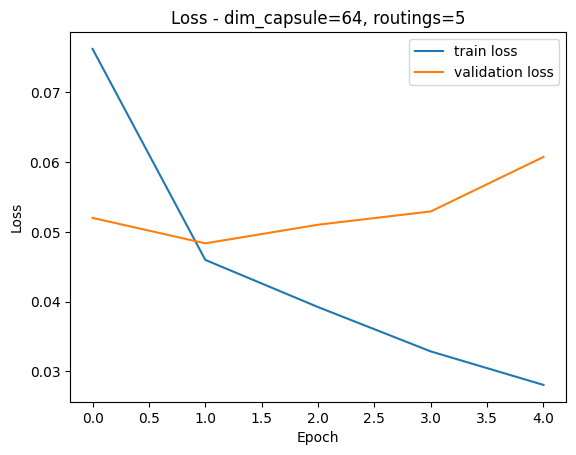


Dim_capsule=64, routings=6...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ (64, 200, 256)         │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (64, 200, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_32 (Conv1D)              │ (64, 196, 64)          │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_32 (MaxPooling1D) │ (64, 49, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_32 (LSTM)                  │ (64, 49, 100)          │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_32 (Capsule)            │ (None, 6, 64)          │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_32 (Flatten)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 6)              │         2,310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,308,694 (20.25 MB)

 Trainable params: 5,308,694 (20.25 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9676 - loss: 0.1165
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing6_epoch01.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 31s 15ms/step - accuracy: 0.9676 - loss: 0.1165 - val_accuracy: 0.9940 - val_loss: 0.0516
Epoch 2/5
1746/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9897 - loss: 0.0465
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing6_epoch02.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.9897 - loss: 0.0465 - val_accuracy: 0.9777 - val_loss: 0.0491
Epoch 3/5
1744/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8919 - loss: 0.0393
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing6_epoch03.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.8919 - loss: 0.0393 - val_accuracy: 0.9940 - val_loss: 0.0500
Epoch 4/5
1744/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8715 - loss: 0.0320
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing6_epoch04.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.8714 - loss: 0.0320 - val_accuracy: 0.8311 - val_loss: 0.0537
Epoch 5/5
1743/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7690 - loss: 0.0277
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing6_epoch05.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 26s 15ms/step - accuracy: 0.7689 - loss: 0.0277 - val_accuracy: 0.9259 - val_loss: 0.0563
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9284 - loss: 0.0554
dim_capsule=64, routings=6 - Validation loss: 0.05625468119978905
dim_capsule=64, routings=6 - Validation accuracy: 0.9258856773376465
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


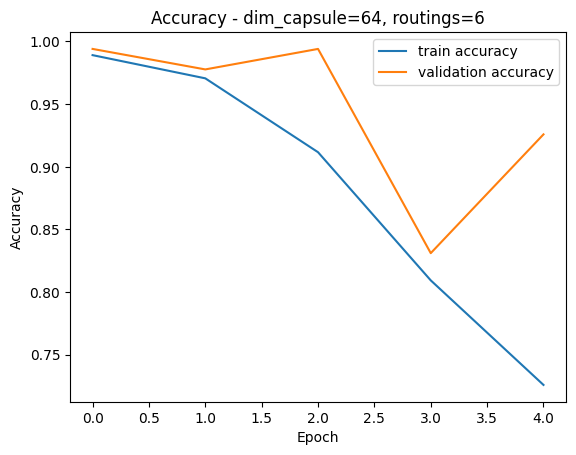

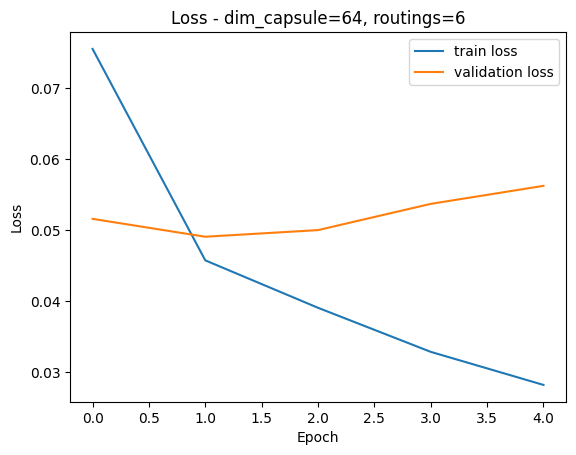


Dim_capsule=64, routings=7...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_33 (Embedding)        │ (64, 200, 256)         │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (64, 200, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_33 (Conv1D)              │ (64, 196, 64)          │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (64, 49, 64)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_33 (LSTM)                  │ (64, 49, 100)          │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capsule_33 (Capsule)            │ (None, 6, 64)          │        38,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_33 (Flatten)            │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 6)              │         2,310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,308,694 (20.25 MB)

 Trainable params: 5,308,694 (20.25 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9602 - loss: 0.1184
Epoch 1: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing7_epoch01.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 32s 16ms/step - accuracy: 0.9602 - loss: 0.1184 - val_accuracy: 0.9940 - val_loss: 0.0507
Epoch 2/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9842 - loss: 0.0458
Epoch 2: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing7_epoch02.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.9842 - loss: 0.0458 - val_accuracy: 0.9940 - val_loss: 0.0486
Epoch 3/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8454 - loss: 0.0376
Epoch 3: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing7_epoch03.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.8454 - loss: 0.0376 - val_accuracy: 0.9906 - val_loss: 0.0492
Epoch 4/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6472 - loss: 0.0301
Epoch 4: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing7_epoch04.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.6472 - loss: 0.0301 - val_accuracy: 0.4766 - val_loss: 0.0545
Epoch 5/5
1745/1746 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5519 - loss: 0.0262
Epoch 5: saving model to /content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim64_routing7_epoch05.h5


1746/1746 ━━━━━━━━━━━━━━━━━━━━ 27s 15ms/step - accuracy: 0.5519 - loss: 0.0262 - val_accuracy: 0.2552 - val_loss: 0.0600
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.2557 - loss: 0.0592
dim_capsule=64, routings=7 - Validation loss: 0.06000445783138275
dim_capsule=64, routings=7 - Validation accuracy: 0.2552431523799896
1496/1496 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


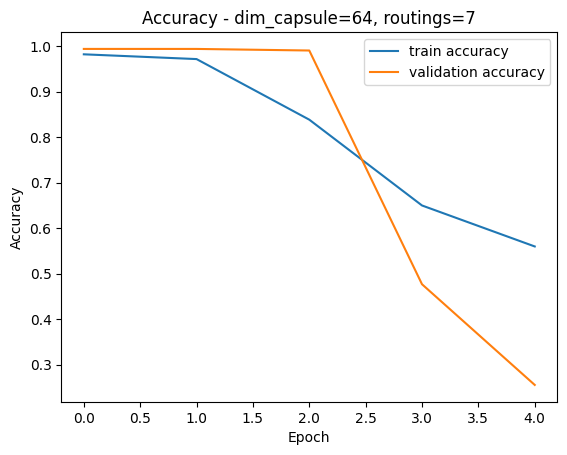

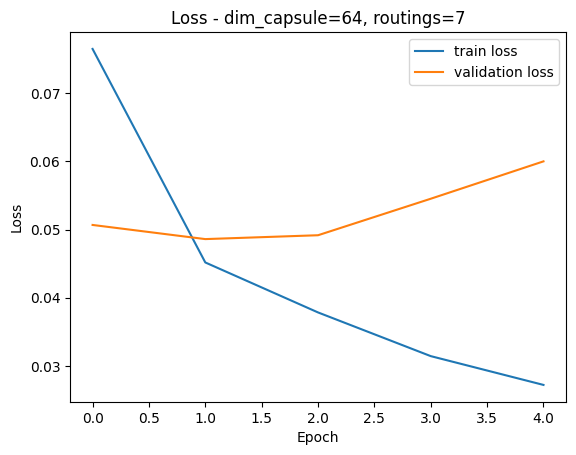

In [ ]:
for dim_capsule, routings in capsule_configs:
    print(f"\nDim_capsule={dim_capsule}, routings={routings}...")

    checkpoint = ModelCheckpoint(
    filepath=f'/content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/model_dim{dim_capsule}_routing{routings}_epoch{{epoch:02d}}.h5',
    save_freq='epoch',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
    )


    model = Sequential([
        Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),
        Dropout(0.2),
        Conv1D(filters=64, kernel_size=5, activation='relu'),
        MaxPooling1D(pool_size=4),
        LSTM(100, return_sequences=True),
        Capsule(num_capsule=6, dim_capsule=dim_capsule, routings=routings, activation=SquashActivation()),
        Flatten(),
        Dense(6, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy']
    )

    # Build the model summary
    model.build((batch_size, max_len))
    print(model.summary())

    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
        callbacks=[checkpoint]
    )

    loss, accuracy = model.evaluate(X_val, y_val)
    print(f'dim_capsule={dim_capsule}, routings={routings} - Validation loss: {loss}')
    print(f'dim_capsule={dim_capsule}, routings={routings} - Validation accuracy: {accuracy}')

    predictions = model.predict(X_val)
    hamming = hamming_loss(np.round(predictions), y_val)
    hamming_losses.append(hamming)

    log_loss_value = log_loss(y_val, predictions)
    log_losses.append(log_loss_value)

    accuracies.append(accuracy)
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Plot accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.title(f'Accuracy - dim_capsule={dim_capsule}, routings={routings}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure()
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title(f'Loss - dim_capsule={dim_capsule}, routings={routings}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# EVALUATION

In [ ]:
from keras.models import load_model
from sklearn.metrics import log_loss, hamming_loss
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import re
from contractions import fix
from nltk.tokenize import word_tokenize
nltk.download('punkt')

# Mount Google Drive
drive.mount('/content/drive')

# Define paths
model_dir = '/content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2'
data_path = '/content/drive/MyDrive/A/A_forSkripsiii/train.csv'
os.makedirs(model_dir, exist_ok=True)

# Load dataset
data = pd.read_csv(data_path)

# Preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', 'url', text)
    text = re.sub(r'@\w+', 'username', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\d+', 'number', text)
    text = fix(text)
    text = ' '.join(word_tokenize(text))
    return text

# Apply preprocessing
text_column = 'comment_text'
data[text_column] = data[text_column].astype(str).apply(preprocess_text)

with open('/content/drive/MyDrive/A/A_forSkripsiii/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Tokenizer settings
max_words = 20000
max_len = 200

sequences = tokenizer.texts_to_sequences(data[text_column])
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Define labels
labels = data[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)

# Initialize results list
results = []

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Loop through model files and evaluate
for model_file in os.listdir(model_dir):
    if model_file.endswith(".h5"):
        model_path = os.path.join(model_dir, model_file)
        print(f"Evaluating model: {model_file}")

        # Load model
        model = load_model(model_path, custom_objects={'Capsule': Capsule, 'SquashActivation': SquashActivation})

        # Predict
        y_pred_prob = model.predict(X_val, verbose=0)

        # Evaluate
        loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
        hamming = hamming_loss(np.round(y_pred_prob), y_val)
        logloss = log_loss(y_val, y_pred_prob)

        # Store metrics
        results.append({
            'Model': model_file,
            'Accuracy': accuracy,
            'Log Loss': logloss,
            'Hamming Loss': hamming
        })

# Results dataframe
results_df = pd.DataFrame(results)
print(results_df)


Evaluating model: model_dim4_routing3_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing3_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing3_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing3_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing3_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing4_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing5_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing6_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim4_routing7_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing3_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing4_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing5_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing6_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim8_routing7_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing3_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing4_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing5_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing6_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim16_routing7_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing3_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing4_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing5_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing4_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing5_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing6_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim32_routing7_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing3_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing6_epoch05.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch01.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch02.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch03.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch04.h5


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Evaluating model: model_dim64_routing7_epoch05.h5
                               Model  Accuracy  Log Loss  Hamming Loss
0     model_dim4_routing3_epoch01.h5  0.990997  0.142547      0.018950
1     model_dim4_routing3_epoch02.h5  0.946294  0.172214      0.017536
2     model_dim4_routing3_epoch03.h5  0.965429  0.187465      0.018184
3     model_dim4_routing3_epoch04.h5  0.994005  0.255510      0.018581
4     model_dim4_routing3_epoch05.h5  0.905310  0.226734      0.018866
..                               ...       ...       ...           ...
120  model_dim64_routing7_epoch01.h5  0.994047  0.185870      0.018128
121  model_dim64_routing7_epoch02.h5  0.994026  0.206937      0.017550
122  model_dim64_routing7_epoch03.h5  0.990558  0.197616      0.017745
123  model_dim64_routing7_epoch04.h5  0.476625  0.224246      0.018490
124  model_dim64_routing7_epoch05.h5  0.255243  0.246956      0.018595

[125 rows x 4 columns]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


In [ ]:
results_df

,Model,Accuracy,Log Loss,Hamming Loss
0,model_dim4_routing3_epoch01.h5,0.990997,0.142547,0.018950
1,model_dim4_routing3_epoch02.h5,0.946294,0.172214,0.017536
2,model_dim4_routing3_epoch03.h5,0.965429,0.187465,0.018184
3,model_dim4_routing3_epoch04.h5,0.994005,0.255510,0.018581
4,model_dim4_routing3_epoch05.h5,0.905310,0.226734,0.018866
...,...,...,...,...
120,model_dim64_routing7_epoch01.h5,0.994047,0.185870,0.018128
121,model_dim64_routing7_epoch02.h5,0.994026,0.206937,0.017550
122,model_dim64_routing7_epoch03.h5,0.990558,0.197616,0.017745
123,model_dim64_routing7_epoch04.h5,0.476625,0.224246,0.018490


In [ ]:
import re

# Function to extract model info
def extract_model_info(name):
    match = re.search(r"model_dim(\d+)_routing(\d+)(?:_epoch(\d+))?", name)
    if match:
        dim = int(match.group(1))
        routing = int(match.group(2))
        epoch = int(match.group(3)) if match.group(3) else 0  # Epoch 0 for full model
        return dim, routing, epoch
    return None, None, None

# Apply extraction
results_df[['Dim', 'Routing', 'Epoch']] = results_df['Model'].apply(
    lambda x: pd.Series(extract_model_info(x))
)

# Sort by Dim, Routing, then Epoch
results_df_sorted = results_df.sort_values(by=['Dim', 'Routing', 'Epoch'])

# Reset index
results_df_sorted.reset_index(drop=True, inplace=True)

# Display
print(results_df_sorted)


                               Model  Accuracy  Log Loss  Hamming Loss  Dim  \
0     model_dim4_routing3_epoch01.h5  0.990997  0.142547      0.018950    4   
1     model_dim4_routing3_epoch02.h5  0.946294  0.172214      0.017536    4   
2     model_dim4_routing3_epoch03.h5  0.965429  0.187465      0.018184    4   
3     model_dim4_routing3_epoch04.h5  0.994005  0.255510      0.018581    4   
4     model_dim4_routing3_epoch05.h5  0.905310  0.226734      0.018866    4   
..                               ...       ...       ...           ...  ...   
120  model_dim64_routing7_epoch01.h5  0.994047  0.185870      0.018128   64   
121  model_dim64_routing7_epoch02.h5  0.994026  0.206937      0.017550   64   
122  model_dim64_routing7_epoch03.h5  0.990558  0.197616      0.017745   64   
123  model_dim64_routing7_epoch04.h5  0.476625  0.224246      0.018490   64   
124  model_dim64_routing7_epoch05.h5  0.255243  0.246956      0.018595   64   

     Routing  Epoch  
0          3      1  
1      

In [ ]:
results_df_sorted

,Model,Accuracy,Log Loss,Hamming Loss,Dim,Routing,Epoch
0,model_dim4_routing3_epoch01.h5,0.990997,0.142547,0.018950,4,3,1
1,model_dim4_routing3_epoch02.h5,0.946294,0.172214,0.017536,4,3,2
2,model_dim4_routing3_epoch03.h5,0.965429,0.187465,0.018184,4,3,3
3,model_dim4_routing3_epoch04.h5,0.994005,0.255510,0.018581,4,3,4
4,model_dim4_routing3_epoch05.h5,0.905310,0.226734,0.018866,4,3,5
...,...,...,...,...,...,...,...
120,model_dim64_routing7_epoch01.h5,0.994047,0.185870,0.018128,64,7,1
121,model_dim64_routing7_epoch02.h5,0.994026,0.206937,0.017550,64,7,2
122,model_dim64_routing7_epoch03.h5,0.990558,0.197616,0.017745,64,7,3
123,model_dim64_routing7_epoch04.h5,0.476625,0.224246,0.018490,64,7,4


In [ ]:
results_df_sorted.to_csv('/content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/capsule_model_results_sorted.csv', index=False)
results_df_sorted.to_excel('/content/drive/MyDrive/A/A_forSkripsiii/ReTrainCNNcp2/capsule_model_results_sorted.xlsx', index=False)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Extract dim_capsule and routings from filenames using regex
results_df['Dim'] = results_df['Model'].str.extract(r'dim(\d+)_')[0].astype(int)
results_df['Routings'] = results_df['Model'].str.extract(r'routing(\d+)')[0].astype(int)
results_df['Epoch'] = results_df['Model'].str.extract(r'epoch(\d+)', expand=False).fillna('05').astype(int)


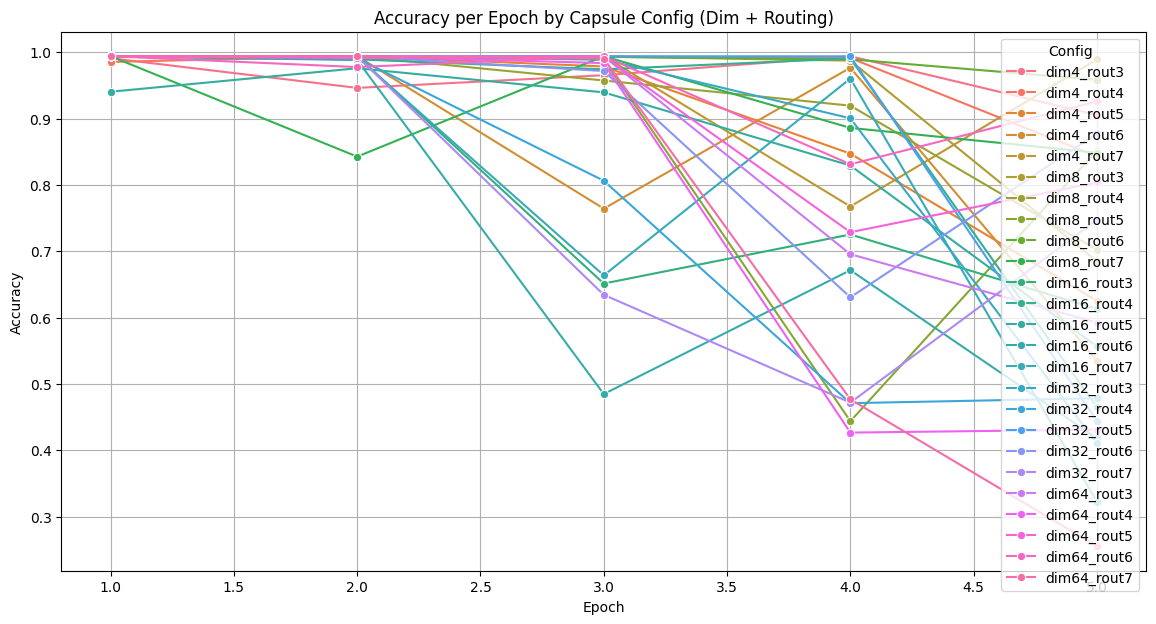

In [ ]:
results_df['Config'] = results_df.apply(lambda row: f'dim{row.Dim}_rout{row.Routings}', axis=1)

plt.figure(figsize=(14, 7))
sns.lineplot(data=results_df, x='Epoch', y='Accuracy', hue='Config', marker='o')
plt.title('Accuracy per Epoch by Capsule Config (Dim + Routing)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Config')
plt.grid(True)
plt.show()


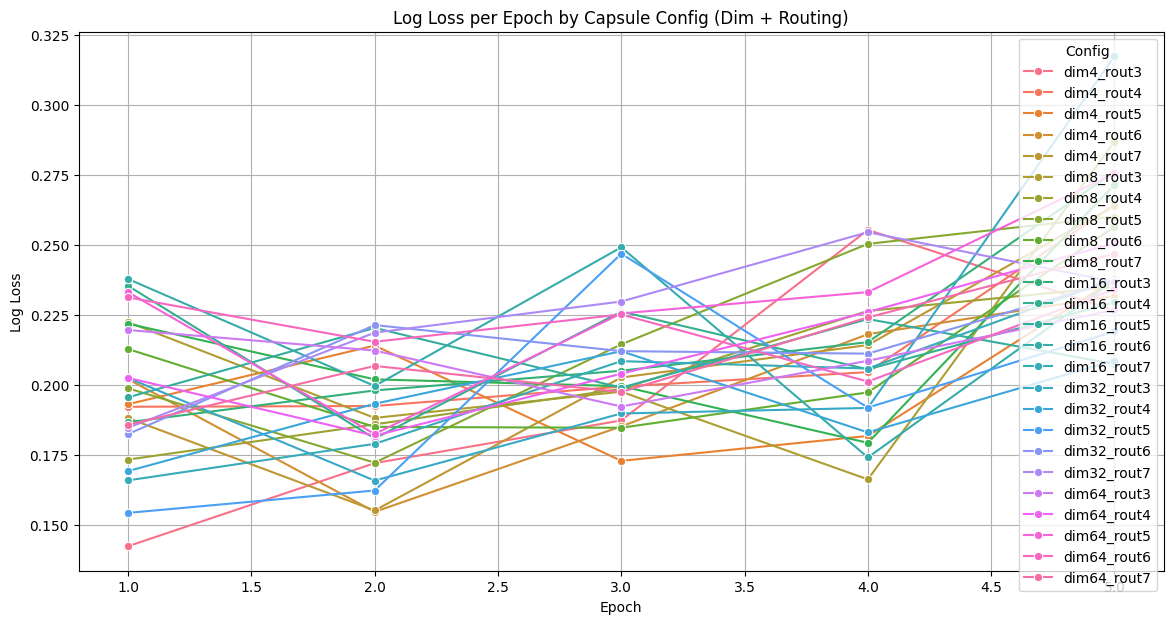

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_df, x='Epoch', y='Log Loss', hue='Config', marker='o')
plt.title('Log Loss per Epoch by Capsule Config (Dim + Routing)')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend(title='Config')
plt.grid(True)
plt.show()


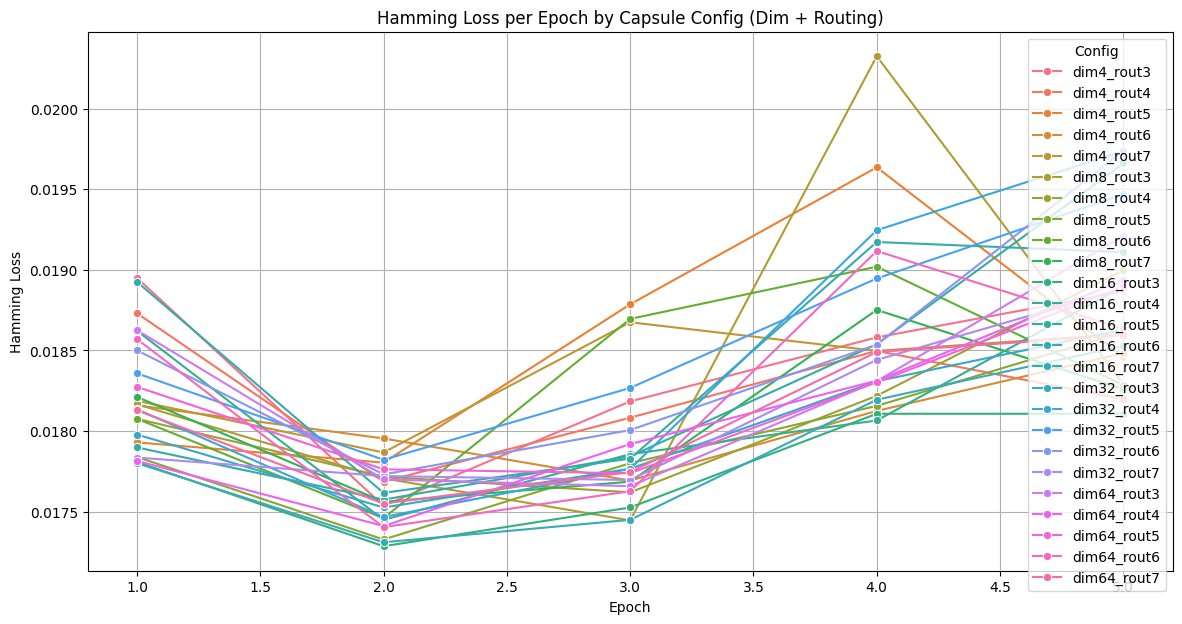

In [ ]:
plt.figure(figsize=(14, 7))
sns.lineplot(data=results_df, x='Epoch', y='Hamming Loss', hue='Config', marker='o')
plt.title('Hamming Loss per Epoch by Capsule Config (Dim + Routing)')
plt.xlabel('Epoch')
plt.ylabel('Hamming Loss')
plt.legend(title='Config')
plt.grid(True)
plt.show()
